# Improving Brewster Paper

In the original paper **General characterization of qubit-preserving impairments on two-qubit Bell nonlocality**, a technique was presented that would correct errors such as polarization misalignments of entangled qubits by optimizing a set of unitary gets for each of the qubits Alice and Bob have. A follow up paper, **Automated Bell inequality violation searches for estimating entanglement quality in fiber**, determined that the Nelder-Mead Method was deemed to be the best method for optimization, though Bayesian Optimization was also quoted as being a close second. 

Previous work on this repo has simulated CHSH games on a quantum network using SeQuEnCe, with more recent additions implementing polarization misalignment and the proposed corrective technique by the above papers. However, we believe that we can improve this process further by utilizing more suitable optimization techniques. The below experiment uses COnstrained Optimization BY Linear Approximation, or COBYLA, to better approximate better alphas in a noisy quantum environment.  

In [1]:
import network_module
from scipy.optimize import minimize
import numpy as np

In [2]:
theta1 = 0.7854          
theta2 = 0          
theta3 = -0.3927        
theta4 = 0.3927

In [3]:
from bayes_opt import BayesianOptimization
import numpy as np
import time

def BayesOPT(deltas, time_limit=400, precision=2500):
    iteration_s_values = []
    time_values = []
    winrate_best = -np.inf
    best_S = 0
    start_time = time.time()

    # Define the CHSH evaluation function with timing and logging
    def simulated_chsh(alpha1, alpha2, alpha3, alpha4, alpha5, alpha6):
        nonlocal best_S,winrate_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit exceeded")

        g = network_module.Game(deltas=deltas, fid=0.9)
        alphas_alice = [alpha1, alpha2, alpha3]
        alphas_bob = [alpha4, alpha5, alpha6]
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        # print(winrate)
        S = g.referee.compute_chsh_s()

        # Log best-so-far S and corresponding timestamp
        if winrate > winrate_best:
            winrate_best = winrate
            best_S = S
        iteration_s_values.append(best_S)
        time_values.append(elapsed)

        return winrate

    # Define bounds
    pbounds = {
        'alpha1': (-np.pi, np.pi),
        'alpha2': (-np.pi, np.pi),
        'alpha3': (-np.pi, np.pi),
        'alpha4': (-np.pi, np.pi),
        'alpha5': (-np.pi, np.pi),
        'alpha6': (-np.pi, np.pi),
    }

    # Set up optimizer
    optimizer = BayesianOptimization(
        f=simulated_chsh,
        pbounds=pbounds,
        verbose=0
    )

    try:
        optimizer.maximize(
            init_points=4,
            n_iter=100000  # allow many iterations; we stop by timeout
        )
    except TimeoutError:
        pass

    total_time = time.time() - start_time
    
    return list(optimizer.max['params'].values()), total_time, iteration_s_values,time_values

In [4]:
from scipy.optimize import minimize
import time
import numpy as np

def Nelder_Mead(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best = -np.inf
    S_best = 0
    S_curve = []
    best_angles = None
    time_curve = []

    def objective(x):
        nonlocal S_best,best_angles,winrate_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        alphas_bob = x[3:6]

        g = network_module.Game(deltas=deltas, fid=0.9)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()

        # print(S_best,best_angles)
        if winrate > winrate_best:
            winrate_best = winrate
            best_angles = x
            S_best = S

        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate  # Minimization

    x0 = np.random.uniform(-np.pi, np.pi, 6)

    try:
        res = minimize(objective, x0, method='Nelder-Mead', options={'maxiter': 10000})
    except TimeoutError:
        pass

    total_time = time.time() - start_time
    return best_angles , total_time, S_curve, time_curve


In [5]:
def COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best = -np.inf
    S_best = 0
    S_curve = []
    time_curve = []
    best_angles = []
    
    def objective(x):
        nonlocal S_best,best_angles,winrate_best
        # print("Alphas:",x)
        # nonlocal S_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        alphas_bob = x[3:6]

        g = network_module.Game(deltas=deltas, fid=0.9)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()
        # print(winrate)
        if winrate > winrate_best:
            winrate_best = winrate
            best_angles = x
            S_best = S

        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate   # Minimization

    # x0 = np.random.uniform(-np.pi, np.pi, 6)
    x0 = np.zeros(6)
    pi_val = np.pi
    cons = []
    for i in range(6):
    # x[i] >= -pi  ->  x[i] + pi >= 0
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] + pi_val})
    # x[i] <= pi   ->  pi - x[i] >= 0
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: pi_val - x[i]})

    try:
        res = minimize(objective, x0, method='COBYLA', constraints=cons,options={'maxiter': 10000})
    except TimeoutError:
        pass
    total_time = time.time() - start_time
    return best_angles, total_time, S_curve, time_curve

In [6]:
# Experiments
import time
num_exp = 20

# Convergence progress
BO_conv = []
NM_conv = []
COB_conv = []

# Time curves (per iteration)
BO_time_curve = []
NM_time_curve = []
COB_time_curve = []

# Validation results
BO_res = []
NM_res = []
COB_res = []

# Total optimization time
BO_time = []
NM_time = []
COB_time = []

for x in range(num_exp):
    print("Iteration:", x)
    deltaA = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltaB = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltas = [deltaA, deltaB]

    # ----- Bayesian Optimization -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = BayesOPT(deltas, time_limit=400, precision=2500)
    end_time = time.time()
    
    BO_conv.append(progress)
    BO_time_curve.append(time_curve)
    BO_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("Validation:", S_high)
    BO_res.append(S_high)

    # ----- Nelder-Mead -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = Nelder_Mead(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    NM_conv.append(progress)
    NM_time_curve.append(time_curve)
    NM_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("VALIDATION:",S_high)
    NM_res.append(S_high) 

    # ----- COBYLA -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    COB_conv.append(progress)
    COB_time_curve.append(time_curve)
    COB_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    result = g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S = g.referee.compute_chsh_s()
    print("VALIDATION:",S)
    COB_res.append(S)


Iteration: 0
Validation: 2.2605976996792543
VALIDATION: 0.07435750169390862


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


VALIDATION: 2.4306429201252118
Iteration: 1
Validation: 2.436155042569587
VALIDATION: 2.4289421098550266
VALIDATION: 2.427509315169749
Iteration: 2
Validation: 2.3070800198073256
VALIDATION: 2.3933962395327097
VALIDATION: 2.4200802865854207
Iteration: 3
Validation: 2.373001483644387
VALIDATION: 2.4211602312662546
VALIDATION: 2.2637582811001593
Iteration: 4
Validation: 2.4344925444670364
VALIDATION: 2.3704432194289122
VALIDATION: 2.363081617775461
Iteration: 5
Validation: 2.053270566831821
VALIDATION: 2.3269330826602648
VALIDATION: 2.4804811564363467
Iteration: 6
Validation: 2.4000645069439432
VALIDATION: 0.020749990859329936
VALIDATION: 2.357779470145591
Iteration: 7
Validation: 2.0168065999344877
VALIDATION: 0.04423849794234225
VALIDATION: 2.344912699610404
Iteration: 8
Validation: 2.4169886922873585
VALIDATION: 2.3816467664851375
VALIDATION: 2.347625787696264
Iteration: 9
Validation: 2.1776398495084424
VALIDATION: 1.289641979704599


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


VALIDATION: 2.4459763525089637
Iteration: 10
Validation: 2.3691004265633175
VALIDATION: 2.5014600687414967
VALIDATION: 2.381557930399178
Iteration: 11
Validation: 2.4049193738697023
VALIDATION: 2.3751265036017033
VALIDATION: 2.4007859438746895
Iteration: 12
Validation: 2.3060478657641292
VALIDATION: 2.346406471112692
VALIDATION: 2.4665968593801413
Iteration: 13
Validation: 2.4198060462687407
VALIDATION: 2.363396271916524
VALIDATION: 2.3463787522281194
Iteration: 14
Validation: 2.4843607704972754
VALIDATION: 2.3794814524288035


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


VALIDATION: 2.4908402738537627
Iteration: 15
Validation: 2.3360194513097534
VALIDATION: 2.304085688184136
VALIDATION: 2.3618454198837755
Iteration: 16
Validation: 1.9483118231372754
VALIDATION: 0.13831810658896893
VALIDATION: 2.2332588462656764
Iteration: 17
Validation: 2.430589298657341
VALIDATION: 2.396159376224742


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


VALIDATION: 2.430501755257322
Iteration: 18
Validation: 2.421705299430625
VALIDATION: 2.186391813664562


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


VALIDATION: 2.300831693799889
Iteration: 19
Validation: 2.419583555342128
VALIDATION: 1.2452831268216729
VALIDATION: 2.4616135518173743


In [15]:
import statistics
print("Mean validation Bayesian Optimization:",statistics.mean(BO_res))
print("Standard Deviation Bayesian Optimization:",statistics.stdev(BO_res))

Mean validation Bayesian Optimization: 2.3208270458256965
Standard Deviation Bayesian Optimization: 0.15388615722115137


In [16]:
print("Mean validation Nelder-Mead:",statistics.mean(NM_res))
print("Standard Deviation Nelder-Mead:",statistics.stdev(NM_res))

Mean validation Nelder-Mead: 1.7993809249356894
Standard Deviation Nelder-Mead: 0.9504549697302839


In [17]:
print("Mean validation COBYLA:",statistics.mean(COB_res))
print("Standard Deviation COBYLA:",statistics.stdev(COB_res))

Mean validation COBYLA: 2.387802945695675
Standard Deviation COBYLA: 0.07068166202636177


In [19]:
print(S,result)

2.4616135518173743 0.8078


In [20]:
def pad_with_last_value(runs):
    max_len = max(len(run) for run in runs)
    padded = np.array([
        np.pad(run, (0, max_len - len(run)), mode='edge')
        for run in runs
    ])
    return padded


In [21]:
BO_time_curve_padded = pad_with_last_value(BO_time_curve)
NM_time_curve_padded = pad_with_last_value(NM_time_curve)
COB_time_curve_padded = pad_with_last_value(COB_time_curve)

BO_conv_padded = pad_with_last_value(BO_conv)
NM_conv_padded = pad_with_last_value(NM_conv)
COB_conv_padded = pad_with_last_value(COB_conv)

# Compute mean + std over runs
BO_time_mean = BO_time_curve_padded.mean(axis=0)
BO_mean = BO_conv_padded.mean(axis=0)
BO_std  = BO_conv_padded.std(axis=0)

NM_time_mean = NM_time_curve_padded.mean(axis=0)
NM_mean = NM_conv_padded.mean(axis=0)
NM_std  = NM_conv_padded.std(axis=0)

COB_time_mean = COB_time_curve_padded.mean(axis=0)
COB_mean = COB_conv_padded.mean(axis=0)
COB_std  = COB_conv_padded.std(axis=0)


In [22]:
NM_res

[0.07435750169390862,
 2.4289421098550266,
 2.3933962395327097,
 2.4211602312662546,
 2.3704432194289122,
 2.3269330826602648,
 0.020749990859329936,
 0.04423849794234225,
 2.3816467664851375,
 1.289641979704599,
 2.5014600687414967,
 2.3751265036017033,
 2.346406471112692,
 2.363396271916524,
 2.3794814524288035,
 2.304085688184136,
 0.13831810658896893,
 2.396159376224742,
 2.186391813664562,
 1.2452831268216729]

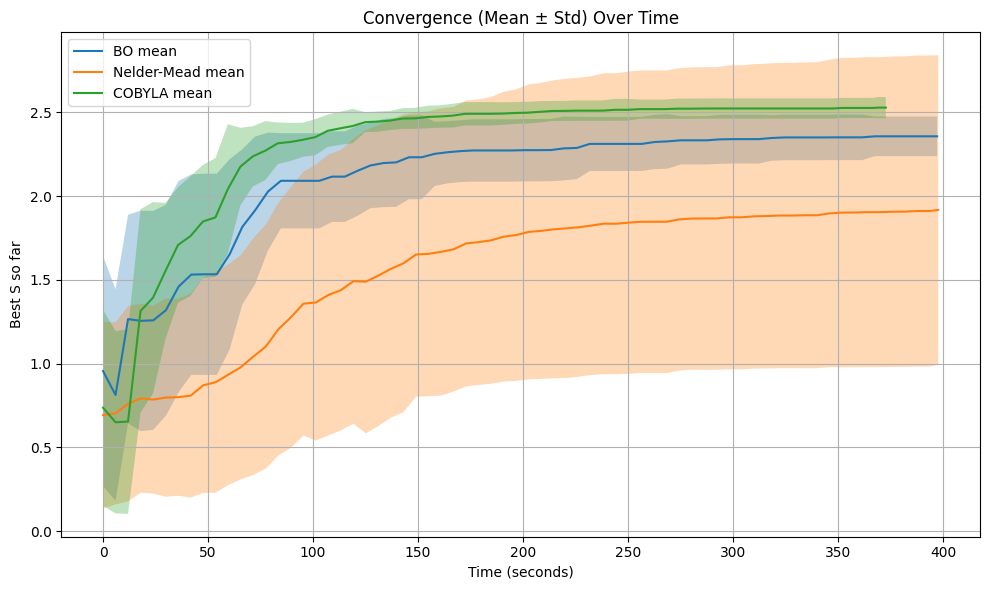

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(BO_time_mean, BO_mean, label='BO mean')
plt.fill_between(BO_time_mean, BO_mean - BO_std, BO_mean + BO_std, alpha=0.3)

plt.plot(NM_time_mean, NM_mean, label='Nelder-Mead mean')
plt.fill_between(NM_time_mean, NM_mean - NM_std, NM_mean + NM_std, alpha=0.3)

plt.plot(COB_time_mean, COB_mean, label='COBYLA mean')
plt.fill_between(COB_time_mean, COB_mean - COB_std, COB_mean + COB_std, alpha=0.3)

plt.xlabel('Time (seconds)')
plt.ylabel('Best S so far')
plt.title('Convergence (Mean ± Std) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()